In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.integrate import simps

In [2]:
data_path = '../data/CALC_STRAIGHT/'
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

In [3]:
print('STRAIGHT SEGMENTS:\t'+ str(len(files)))

STRAIGHT SEGMENTS:	232


In [4]:
#A = pd.read_csv('../data/STRAIGHT_STEP_FREQ.csv')
#for file in A.File: A.loc[A.File==file,'Subject'] = file.split('Char00')[0]+'Char00'
A = pd.read_csv('../data/FEATURES.csv')
A.head()

,File,IndexStart,IndexEnd,StepsL,StepsR,Ts,SegLen,TimeLen,StepFreqL,StepFreqR,Type,StepLenL,StepLenR,XY_LenL,XY_LenR,sd_x,sd_y,sd_z,sd,Subject
0,N-15-1-Char00part2seg-0.csv,24774.0,25295.0,7.0,7.0,0.017,522.0,8.874,0.788821,0.788821,N,1.483460,1.405821,1.287588,1.288669,0.117855,0.347137,0.026994,0.093392,N-15-1-Char00
1,N-15-1-Char00part3seg-0.csv,25433.0,26395.0,12.0,13.0,0.017,963.0,16.371,0.733003,0.794087,N,1.488186,1.435724,1.299253,1.309069,0.078074,0.361828,0.013962,0.199849,N-15-1-Char00
2,N-04-1-Char00part7seg-3.csv,57701.0,59747.0,13.0,14.0,0.008,2047.0,16.376,0.793845,0.854910,N,1.595290,1.359651,1.220835,1.212410,0.124427,0.332240,0.020180,0.348420,N-04-1-Char00
3,A-736123-Char00part1seg-0.csv,2900.0,4287.0,18.0,18.0,0.017,1388.0,23.596,0.762841,0.762841,A,1.297358,1.304605,1.135841,1.132741,0.086197,0.312531,0.011302,0.307024,A-736123-Char00
4,N-15051994-Char00part2seg-0.csv,18500.0,20250.0,13.0,13.0,0.008,1751.0,14.008,0.928041,0.928041,N,1.426764,1.430061,1.295509,1.293005,0.029466,0.361615,0.011693,0.361092,N-15051994-Char00


In [5]:
def module(joint):
    N = np.size(joint,axis=0)
    module = np.zeros((N))
    for n in range(0,N):
        module[n] = ((joint.iloc[n,0])**2+(joint.iloc[n,1])**2+(joint.iloc[n,2])**2)**(1/2)
    return module

In [6]:
def fft_bands(df,T_sampling,low1,high1,low2,high2):
    Fs = 1.0/T_sampling; # sampling frequency
    n = np.size(df,axis=0) # length of the signal
    
    if n%2==1:
        n-=1
        df = df[:-1]
        
    B = df-np.mean(df,axis=0)   
    
    t = np.arange(0,n*T_sampling,T_sampling) # time vector
        
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range
    
    # Find intersecting values in frequency vector
    idx_delta1 = np.logical_and(frq >= low1, frq < high1)
    idx_delta2 = np.logical_and(frq >= low2, frq < high2)

    Y = np.fft.fft(B)/n # fft computing and normalization
    Y = Y[range(int(n/2))]
    
    # Frequency resolution
    freq_res = frq[1] - frq[0]

    # Compute the absolute power by approximating the area under the curve
    delta_power1 = simps(abs(Y[idx_delta1]), dx=freq_res)
    delta_power2 = simps(abs(Y[idx_delta2]), dx=freq_res)
    
    total_power = simps(abs(Y), dx=freq_res)
    delta_rel_power1 = delta_power1 / total_power
    delta_rel_power2 = delta_power2 / total_power
    
    return delta_rel_power1,delta_rel_power2

In [7]:
for file in files:
    
    low1, high1 = 3, 15
    low2, high2 = 15, 30

    print(file)
    
    df = pd.read_csv(data_path + file)
    
    accel_cols = [s for s in df.columns.to_list() if "A" in s]
    adf = df.filter(accel_cols,axis=1)
    
    T_sampling = A.loc[A['File'] == file,'Ts'].values
    
    AA = pd.DataFrame()
    for joint in range(1,60):
        joint_cols = []
        for col in accel_cols:
            if str(joint) in col:
                joint_cols.append(accel_cols.index(col))
        this_joint = adf.filter(adf.columns[joint_cols],axis=1)
        AA[str(joint)] = module(this_joint)
    
    for joint in range(0,59):
        e1,e2 = fft_bands(AA.iloc[:,joint],T_sampling,low1,high1,low2,high2)        
        A.loc[A['File'] == file,'EnergyBand_3_15_'+str(joint)] = e1
        A.loc[A['File'] == file,'EnergyBand_15_30_'+str(joint)] = e2

N-15-1-Char00part2seg-0.csv


/Users/tupa/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/Users/tupa/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


N-15-1-Char00part3seg-0.csv
N-04-1-Char00part7seg-3.csv
A-736123-Char00part1seg-0.csv
N-15051994-Char00part2seg-0.csv
N-15051994-Char00part3seg-0.csv
N-920828-Char00part1seg-0.csv
N-04-1-Char00part7seg-2.csv
N-15-1-Char00part3seg-1.csv
N-535525-Char00part1seg-8.csv
N-15-1-Char00part3seg-3.csv
N-04-1-Char00part7seg-0.csv
N-04-1-Char00part6seg-0.csv
N-04-1-Char00part7seg-1.csv
N-15-1-Char00part3seg-2.csv
N-15051994-Char00part8seg-0.csv
N-740516-Char00part5seg-0.csv
N-740516-Char00part4seg-0.csv
N-07-1-Char00part1seg-19.csv
N-25031996-Char00part3seg-10.csv
N-04-1-Char00part7seg-4.csv
N-07-1-Char00part1seg-18.csv
N-01-1-Char00part1seg-0.csv
N-740516-Char00part4seg-1.csv
N-25031996-Char00part1seg-0.csv
N-740516-Char00part4seg-3.csv
N-14-2-Char00part1seg-0.csv
N-10-1-Char00part5seg-0.csv
N-06-1-Char00part1seg-0.csv
N-10-1-Char00part4seg-0.csv
A-715211-Char00part2seg-0.csv
N-740516-Char00part4seg-2.csv
A-715211-Char00part1seg-8.csv
N-07-1-Char00part1seg-0.csv
N-25031996-Char00part3seg-9.csv
N

Text(0.5, 0, 'Relative Energy [0,1]')

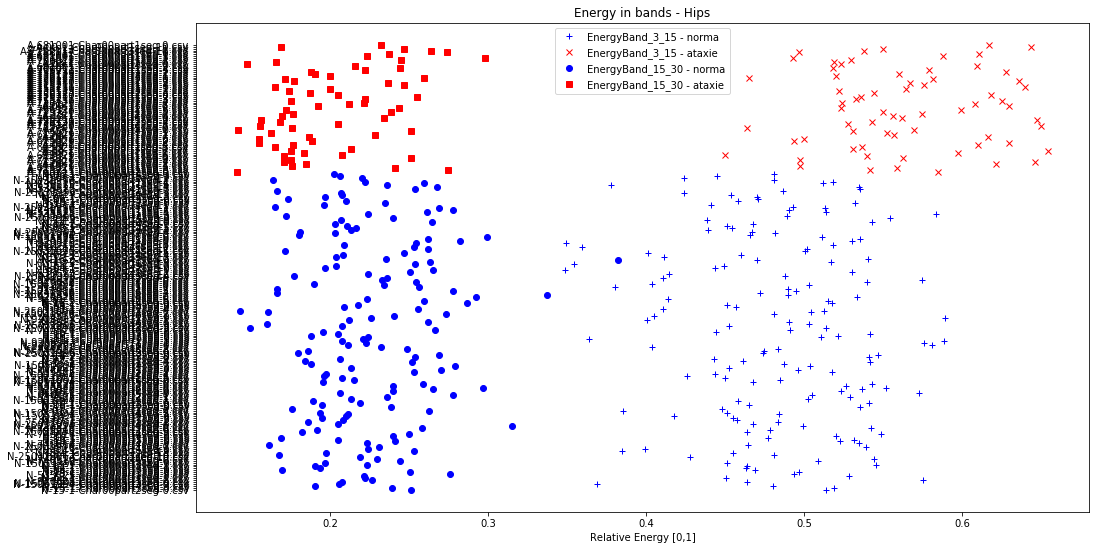

In [8]:
fig = plt.figure(figsize=(16,9))
plt.plot(A.loc[A.Type=='N','EnergyBand_3_15_1'],A.loc[A.Type=='N','File'],'b+')
plt.plot(A.loc[A.Type=='A','EnergyBand_3_15_1'],A.loc[A.Type=='A','File'],'rx')
plt.plot(A.loc[A.Type=='N','EnergyBand_15_30_1'],A.loc[A.Type=='N','File'],'bo')
plt.plot(A.loc[A.Type=='A','EnergyBand_15_30_1'],A.loc[A.Type=='A','File'],'rs')
plt.title('Energy in bands - Hips')
plt.legend(['EnergyBand_3_15 - norma','EnergyBand_3_15 - ataxie','EnergyBand_15_30 - norma','EnergyBand_15_30 - ataxie'])
plt.xlabel('Relative Energy [0,1]')

Text(0.5, 0, 'Relative Energy [0,1]')

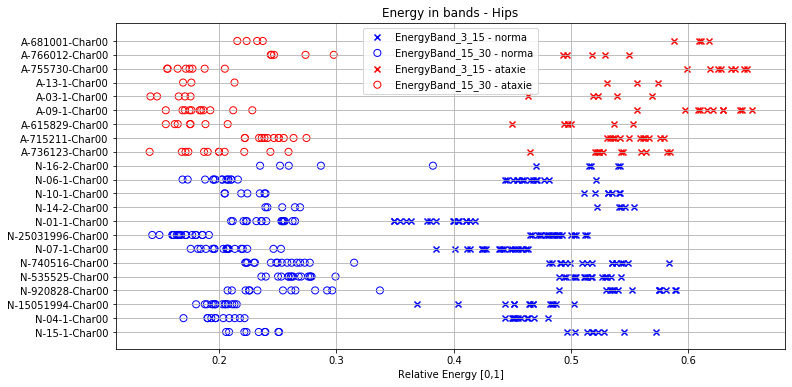

In [9]:
plt.figure(figsize=(12,6))
sub=A.loc[A['Type'] == 'N']
plt.scatter(x=sub.EnergyBand_3_15_1,y=sub.Subject,c='b',marker='x')
plt.scatter(x=sub.EnergyBand_15_30_1,y=sub.Subject,facecolors='none',s=50,edgecolors='b')
sub=A.loc[A['Type'] == 'A']
plt.scatter(x=sub.EnergyBand_3_15_1,y=sub.Subject,c='r',marker='x')
plt.scatter(x=sub.EnergyBand_15_30_1,y=sub.Subject,facecolors='none',s=50,edgecolors='r')
plt.grid()
plt.title('Energy in bands - Hips')
plt.legend(['EnergyBand_3_15 - norma','EnergyBand_15_30 - norma','EnergyBand_3_15 - ataxie','EnergyBand_15_30 - ataxie'])
plt.xlabel('Relative Energy [0,1]')

In [10]:
A.to_csv('../data/FEATURES.csv',index=False)